In [33]:
import numpy as np
from cosmoTransitions import generic_potential
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc


%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size



label_size=20
thick_size=20

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
#data = np.loadtxt( 'satoshi_dof.dat' )[500:3900]
#Temperature_d=(data.T)[0]
#dof_d=(data.T)[1]#relativistic degrees of freedom  
#dof_s=(data.T)[3]#entropic degrees of freedom
#g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
#g_star_s = interpolate.interp1d(Temperature_d, dof_s, kind='cubic')
def whole_program(X,muscale=1000):
    """This function is used to find the initial conditions (mass term and quartic coupling) 
    that yield the correct minimization conditions (v=246,mh=125)"""
    muh,lam= X
    V0=lambda h: -h**2*muh**2/2 + lam*h**4/4
    vev_tree= (muh**2/lam)**.5
    def V_full(h):
        Mh2=3*h**2*lam-muh**2
        MG2=h**2*lam-muh**2
        VCW=Mh2**2*(np.log(np.sqrt(Mh2**2)/muscale**2)-1/2)
        VCW+=MG2**2*(np.log(np.sqrt(MG2**2)/muscale**2)-1/2)
        VCW*=1/64/np.pi**2
        return V0(h)+VCW  
    hmin=optimize.fmin(V_full,x0=vev_tree,disp=False)[0]
    dV=misc.derivative(V_full, x0=hmin, n=1)
    d2V=misc.derivative(V_full, x0=hmin, n=2)
    return 1*abs(d2V**.5-mh)**2+1*abs(hmin-v)**2



#whole_program([(mh**2/2)**.5,mh**2/2/v**2]) 

fix_init_conds=optimize.minimize(whole_program,x0=[(mh**2/2)**.5,mh**2/2/v**2],args=(500))
fix_init_conds


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


      fun: 2.4412750030304697e-10
 hess_inv: array([[2.63595634e-01, 7.88759335e-04],
       [7.88759335e-04, 2.92616773e-06]])
      jac: array([-2.85965725e-08,  1.92763920e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 137
      nit: 6
     njev: 42
   status: 2
  success: False
        x: array([88.66793203,  0.13153409])

In [2]:
class model1(generic_potential.generic_potential):
    def init(self, Lam):
        self.Lam=Lam
        self.Ndim = 1
        self.renormScaleSq=Lam**2
        
        fix_init_conds=optimize.minimize(whole_program,x0=[(mh**2/2)**.5,mh**2/2/v**2],args=(Lam))
        self.muh, self.lam=fix_init_conds.x
        


    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h= X[...]
        pot = -h**2/2*self.muh**2 + h**4*self.lam/4
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h = X[...,]
               
        mh=3*h**2*self.lam-self.muh**2
        mGB=h**2*self.lam-self.muh**2


        M = np.array([mh,mGB])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,3]) ##Longitudinal at the end
        c = np.array([.5,.5])

        return M, dof, c
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = 0*np.array([12])
        return M, dof


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v])]

In [3]:
m=model1(1000)

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply


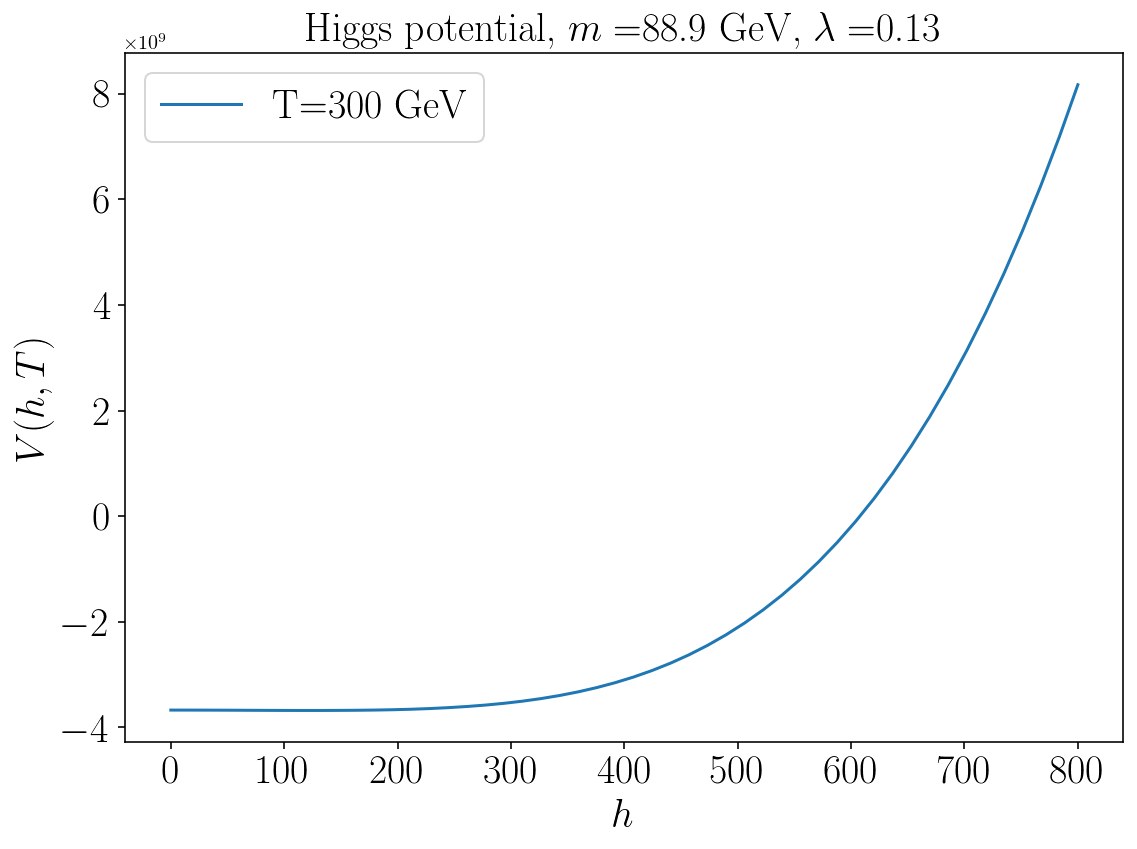

In [74]:
h_range=np.linspace(0,800)
#V_range=[m.Vtot([h],v) for h in h_range]
#plt.plot(h_range,V_range)
temp=300
plt.plot(h_range,m.Vtot(h_range,temp,include_radiation=False),label="T="+str(temp)+" GeV")
#temp=300
#plt.plot(h_range,m.Vtot(h_range,temp,include_radiation=False),label="T="+str(temp)+" GeV")
#temp=200
#plt.plot(h_range,m.Vtot(h_range,temp,include_radiation=False),label="T="+str(temp)+" GeV")

plt.xlabel("$h$ ",size=label_size)
plt.ylabel("$V(h,T)$",size=label_size)
#plt.xscale("log")
#plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.legend(loc="best",prop={'size': label_size})
plt.title("Higgs potential, $m=$"+str(np.round(m.muh,1)) +" GeV, $\lambda=$"+str(np.round(m.lam,2)),size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/SM_potential.pdf', dpi=300)
plt.show()

In [49]:
(mh**2/2)**.5,mh**2/2/v**2

(88.45198725862524, 0.12907409604048145)

In [66]:
misc.derivative(m.Vtot,x0=v+.04,args=(0,),n=1)

36.5489676296711